# CASCON Deep Learning Tutorial with Tensorflow 2.0

In Tensorflow 2.0, the majority of the environment is in 'Eager Execution'. This means that, like typical python, it is a define by run environment. If you are worried about speed, training steps and tensor executions can be run inside a tf.funciton wrapped function. This will make tensorflow auto-graph and optimize the graph for the function execution.

Finally, we recommend always having the API for Tensorflow 2.0 up while coding, so here it is: [TF-2.0](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf)

We will begin by installing our required packages and check out the hardware we're working with ! 


In [1]:
!pip install tensorflow-gpu==2.0.0rc graphviz numpy tqdm matplotlib --no-cache-dir 
!nvidia-smi

     |████████████████████████████████| 380.5MB 60.0MB/s 
     |████████████████████████████████| 501kB 44.4MB/s 
     |████████████████████████████████| 4.3MB 46.0MB/s 
Tue Oct 29 00:57:19 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                              

# Import packages and version check

In [0]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [3]:
tf.__version__

'2.0.0-rc0'

# MNIST Challenge

The MNIST dataset is a common challenge where the goal is to classify pictures of handwritten numbers that range from 0-9. 

Objective:
Classify 28x28 images of handwritten numbers with a single label within the range 0 to 9.

We begin by loading in the dataset.



In [4]:
(train_x,train_y),(test_x,test_y) = tf.keras.datasets.mnist.load_data()

print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

11493376/11490434 [==============================] - 1s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


# Transforming and normalizing the data

In [0]:
train_x, test_x = train_x/255., test_x/255.
train_x = np.expand_dims(train_x,-1)
train_y = np.expand_dims(train_y,-1)
test_x = np.expand_dims(test_x,-1)
test_y = np.expand_dims(test_y,-1)
train_x = train_x.astype(np.float32)
test_x = test_x.astype(np.float32)

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x,train_y)).shuffle(1000).batch(10)
test_ds = tf.data.Dataset.from_tensor_slices((test_x,test_y)).shuffle(1000).batch(10)

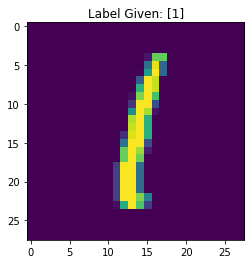

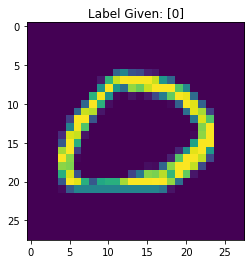

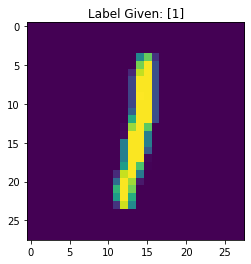

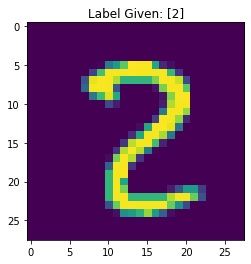

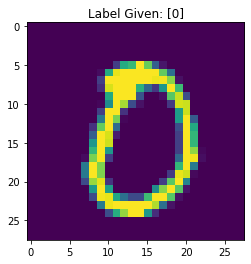

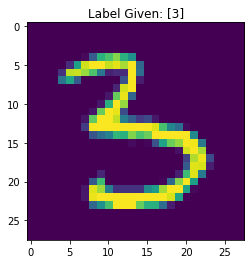

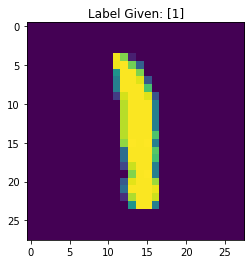

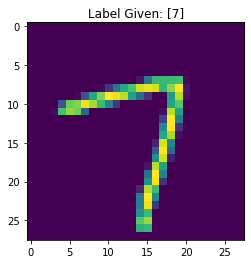

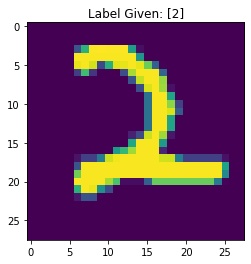

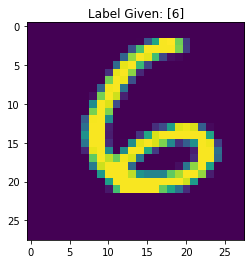

In [8]:
for i in range(10):
    inp,labels = next(test_ds.__iter__())
    ind = np.random.randint(0,inp.shape[0])
    plt.title("Label Given: {}".format(labels[ind]))
    plt.imshow(inp[ind,:,:,0])
    plt.show()

# Defining our network

In [0]:
class MNIST_Model(tf.keras.Model):
    def __init__(self,num_classes = 10):
        super(MNIST_Model,self).__init__()
        self.num_classes = num_classes
        self.f = tf.keras.layers.Flatten()
        self.d = tf.keras.layers.Dense(128,activation=tf.nn.relu)
        self.o = tf.keras.layers.Dense(num_classes,activation=tf.nn.softmax)


    def call(self,x):
        x = self.f(x)
        x = self.o(x)
        return x

In [0]:
num_classes = 10
model = MNIST_Model(num_classes)

# Defining metrics and hyperparameters

In [0]:
# Set hyperparameters (number of classes, batch sizes, number of epochs)
num_classes = 10
bs = 256
num_epochs = 10

In [0]:
# define objective and optimizer
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [0]:
# define what we mean by accuracy
train_loss = tf.keras.metrics.Mean()
train_acc = tf.keras.metrics.SparseCategoricalAccuracy()
test_acc = tf.keras.metrics.SparseCategoricalAccuracy()

# Training our Model

In [0]:
def train_step(inp, labels):
    with tf.GradientTape() as tape:
        preds = model(tf.cast(inp,tf.float32))
        loss = loss_obj(labels,preds)
    gradients = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))

    train_loss(loss)
    train_acc(labels,preds)



In [21]:
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    train_loss.reset_states()
    train_acc.reset_states()
    for inp,labels in train_ds:
        train_step(inp,labels)
    pbar.set_description('Epoch %2d: loss=%2.5f, acc=%2.5f' %
          (epoch,train_loss.result().numpy(),train_acc.result().numpy()))


  0%|          | 0/10 [00:00<?, ?it/s]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch  9: loss=0.24840, acc=0.93132: 100%|██████████| 10/10 [12:51<00:00, 76.79s/it]


# Evaluate our model

In [0]:
@tf.function
def test_step(inp,labels):
    preds = model(inp)
    test_acc(labels,preds)

In [23]:
for inp,labels in test_ds:
    test_step(inp,labels)
print("Final accuracy: %.4f" %(test_acc.result().numpy()))

Final accuracy: 0.9236


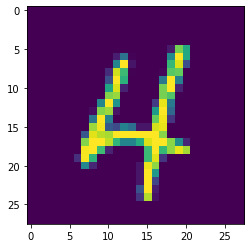

Actual Label:  4
Output Logits:  [9.5761723e-05 1.7561733e-06 7.0887408e-04 7.9109659e-06 9.9144745e-01
 2.5795843e-04 6.1042135e-04 7.5036864e-06 4.8460611e-04 6.3777836e-03]
Predicted Label:  4


In [24]:
inp,labels = next(test_ds.__iter__())
ind = np.random.randint(0,inp.shape[0])
plt.imshow(inp[ind,:,:,0])
plt.show()
print("Actual Label: ",labels[ind,0].numpy())
print("Output Logits: ", model(inp)[ind,...].numpy())
print("Predicted Label: ", tf.argmax(model(inp)[ind,...]).numpy())